# Gaussian Naive Bayes - Lab

## Introduction

Now that you've seen how to employ multinomial Bayes for classification, its time to practice implementing the process yourself. You'll also get a chance to investigate the impacts of using true probabilities under the probability density function as opposed to the point estimate on the curve itself.

## Objectives

You will be able to:

* Independently code and implement the Gaussian Naive Bayes algorithm

## Load the dataset

To get started, load the dataset stored in the file `'heart.csv'`. The dataset contains various measurements regarding patients and a `'target'` feature indicating whether or not they have heart disease. You'll be building a GNB classifier to help determine whether future patients do or do not have heart disease. As reference, this dataset was taken from Kaggle. You can see the original data post here: https://www.kaggle.com/ronitf/heart-disease-uci.

In [2]:
# Your code here 
# Load the dataset
import pandas as pd
import numpy as np

df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Define the problem

As discussed, the dataset contains various patient measurements along with a `'target'` variable indicating whether or not the individual has heart disease. Define `X` and `y` below: 

In [3]:
# Your code here
y = df['target']
X = df.drop(columns=['target'], axis=1)

## Perform a Train-test split

While not demonstrated in the previous lesson, you've seen from your work with regression that an appropriate methodology to determine how well your algorithm will generalize to new data is to perform a train-test split. 

> Note: Set `random_state` to 22 and `test_size` to 0.25 to have your results match those of the solution branch provided.

In [4]:
# Your code here
# Perform a train-test split 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=22)

## Calculate the mean & standard deviation of each feature for each class in the training set

Now, calculate the mean and standard deviation for each feature within each of the target class groups. This will serve as your a priori distribution estimate to determine the posterior likelihood of an observation belonging to one class versus the other.

In [6]:
# Your code here 
# Calculate the mean and standard deviation for each feature within each class for the training set
aggs = df.groupby('target').agg(['mean', 'std'])
aggs

age                 sex                  cp            \
             mean       std      mean       std      mean       std   
target                                                                
0       56.601449  7.962082  0.826087  0.380416  0.478261  0.905920   
1       52.496970  9.550651  0.563636  0.497444  1.375758  0.952222   

          trestbps                   chol               ...        exang  \
              mean        std        mean        std    ...         mean   
target                                                  ...                
0       134.398551  18.729944  251.086957  49.454614    ...     0.550725   
1       129.303030  16.169613  242.230303  53.552872    ...     0.139394   

                   oldpeak               slope                  ca            \
             std      mean       std      mean       std      mean       std   
target                                                                         
0       0.499232  1.585507  1.300340  1.166667  0.561324  1.166667  1.043460   
1       0.347412  0.583030  0.780683  1.593939  0.593635  0.363636  0.848894   

            thal            
            mean       std  
target                      
0       2.543478  0.684762  
1       2.121212  0.465752  

[2 rows x 26 columns]

## Define a function to calculate the point estimate for the conditional probability of a feature value for a given class

Recall that the point estimate is given by the probability density function of the normal distribution:  

 $$ \large P(x_i|y) = \frac{1}{\sqrt{2 \pi \sigma_i^2}}e^{\frac{-(x-\mu_i)^2}{2\sigma_i^2}}$$

> Note: Feel free to use the built-in function from SciPy to do this as demonstrated in the lesson. Alternatively, take the time to code the above formula from scratch.

In [9]:
from scipy import stats
def p_x_given_class(obs_row, feature, class_):
    mu = aggs[feature]['mean'][class_]
    std = aggs[feature]['std'][class_]
    
    #Observation
    obs = obs_row[feature]
    
    p_x_given_y = stats.norm.pdf(obs, loc=mu, scale=std)
    return p_x_given_y
p_x_given_class(X_train.iloc[0], X.columns[0], 0)

0.03253766760429478

## Define a prediction function 

Define a prediction function that will return a predicted class value for a particular observation. To do this, calculate the point estimates for each of the features using your function above. Then, take the product of these point estimates for a given class and multiply it by the probability of that particular class. Take the class associated with the largest probability output from these calculations as your prediction.

In [10]:
def predict_class(obs_row):
    c_probs = []
    for c in range(2):
        #Initialize probability to relative probability of class
        p = len(y_train[y_train == c])/len(y_train)
        for feature in X.columns:
            p *= p_x_given_class(obs_row, feature, c)
        c_probs.append(p)
    return np.argmax(c_probs)

In [13]:
predict_class(X_train.iloc[0])

0

## Apply your prediction function to the training and test sets

In [14]:
y_hat_train = [predict_class(X_train.iloc[idx]) for idx in range(len(X_train))]
y_hat_test = [predict_class(X_test.iloc[idx]) for idx in range(len(X_test))]

## Calculate the training and test accuracy

In [16]:
residuals_train = y_hat_train == y_train
acc_train = residuals_train.sum()/len(residuals_train)

residuals_test = y_hat_test == y_test
acc_test = residuals_test.sum()/len(residuals_test)

print('Training Accuracy: {}\tTesting Accuracy: {}'.format(acc_train, acc_test))

Training Accuracy: 0.8414096916299559	Testing Accuracy: 0.8289473684210527


## Level up (Optional)

### Adapting point estimates for the conditional probability into true probability estimates

As discussed, the point estimate from the probability density function is not a true probability measurement. Recall that the area under a probability density function is 1, representing the total probability of all possible outcomes. Accordingly, to determine the probability of a feature measurement occurring, you would need to find the area under some portion of the PDF. Determining appropriate bounds for this area however, is a bit tricky and arbitrary. For example, when generating a class prediction, you would want to know the probability of a patient having a resting blood pressure of 145 given that they had heart disease versus the probability of having a resting blood pressure of 145 given that the did not have heart disease. Previously, you've simply used the point where x=145 on the PDF curve to do this. However, the probability of any single point is actually 0. To calculate the actual probability, you would have to create a range around the observed value such as "what is the probability of having a resting blood pressure between 144 and 146 inclusive?" Alternatively, you could narrow the range and rewrite the problem as "what is the probability of having a resting blood pressure between 144.5 and 145.5?" Since defining these bounds is arbitrary, a potentially interesting research question is how various band methods might impact output predictions and the overall accuracy of the algorithm.


## Rewriting the conditional probability formula

Rewrite your conditional probability formula above to take a feature observation, a given class, and a range width and calculate the actual probability beneath the PDF curve of an observation falling within the range of the given width centered at the given observation value. For example, taking the previous example of resting blood pressure, you might calculate the probability of having a resting blood pressure within 1bp of 145 given that a patient has heart disease. In this case, the range width would be 2bp (144bp to 146bp) and the corresponding area under the PDF curve for the normal distribution would look like this:  

<img src="images/pdf_integral.png">

With that, write such a function below: 

In [30]:
def p_band_x_given_class(obs_row, feature, c, range_width_std):
    """obs_row is the observation in question 
    feature is the feature of the observation row for which you are calculating a conditional probability 
    c is the class flag for the conditional probability 
    range_width_std is the range in standard deviations of the feature variable to calculate the integral under the PDF curve for"""
    # Your code here 
    mu = aggs[feature]['mean'][c]
    std = aggs[feature]['std'][c]
    
    obs = obs_row[feature]
    interval_min = obs - range_width_std*std/2
    interval_max = obs + range_width_std*std/2
    
    cdf_min = stats.norm.cdf(interval_min, loc=mu, scale=std)
    cdf_max = stats.norm.cdf(interval_max, loc=mu, scale=std)
    p_x_given_y = cdf_max - cdf_min
    return p_x_given_y

## Update the prediction function

Now, update the `predict_class()` function to use this new conditional probability function. Be sure that you can pass in the range width variable to this wrapper function.

In [31]:
# Your code here
def predict_class(obs_row, how='bands', range_width_std=0.25):
    c_probs = []
    for c in range(2):
        # Initialize probability to relative probability of class
        p = len(y_train[y_train == c])/len(y_train) 
        for feature in X.columns:
            if how == 'bands':
                p *= p_band_x_given_class(obs_row, feature, c, range_width_std=range_width_std)
            else:
                p *= p_x_given_class(obs_row, feature, c)
        c_probs.append(p)
    return np.argmax(c_probs)  

## Experiment with the impact of various range-widths

Finally, write a `for` loop to measure the impact of varying range-widths on the classifier's test and train accuracy. Iterate over various range-widths from 0.1 standard deviations to 2 standard deviations. For each of these, store the associated test and train accuracies. Finally, plot these on a graph. The x-axis should be the associated range-width (expressed in standard deviations; each feature will have a unique width applicable to the specific scale). The y-axis will be the associated accuracy. Be sure to include a legend for train accuracy versus test accuracy.

_Note:_ ⏰ _Expect your code to take over two minutes to run._

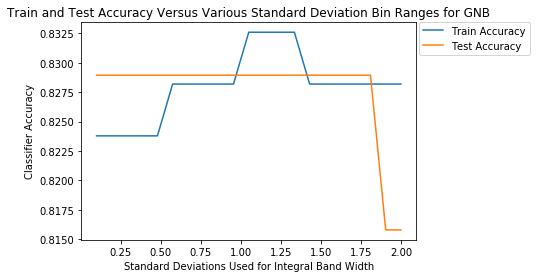

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

train_accs = []
test_accs = []
range_stds = np.linspace(0.1, 2, num=21)
for range_std in range_stds:
    y_hat_train = [predict_class(X_train.iloc[idx], range_width_std=range_std) for idx in range(len(X_train))]
    y_hat_test = [predict_class(X_test.iloc[idx], range_width_std=range_std) for idx in range(len(X_test))]
    
    residuals_train = y_hat_train == y_train
    acc_train = residuals_train.sum()/len(residuals_train)
    
    residuals_test = y_hat_test == y_test
    acc_test = residuals_test.sum()/len(residuals_test)
    
    train_accs.append(acc_train)
    test_accs.append(acc_test)
    
plt.plot(range_stds, train_accs, label='Train Accuracy')
plt.plot(range_stds, test_accs, label='Test Accuracy')
plt.title('Train and Test Accuracy Versus Various Standard Deviation Bin Ranges for GNB')
plt.ylabel('Classifier Accuracy')
plt.xlabel('Standard Deviations Used for Integral Band Width')
plt.legend(loc=(1.01, 0.85));

> Comment: Not a wild difference from our point estimates obtained by using points from the PDF itself, but there is some impact. **Interestingly, these graphs will differ substantially in shape depending on the initial train-test split used.** The recommendation would be to use the point estimates from the PDF itself, or a modest band-width size.

## Appendix: Plotting PDFs and probability integrals

Below, feel free to take a look at the code used to generate the PDF graph image above.

In [33]:
temp = df[df['target'] == 1]['trestbps']
aggs = temp.agg(['mean', 'std'])
aggs

mean    129.303030
std      16.169613
Name: trestbps, dtype: float64

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import seaborn as sns
import scipy.stats as stats
sns.set_style('white')

Probability of Blood Pressure Falling withing Range for the Given Class: 0.03080251623846919


Text(0.5, 0, 'Resting Blood Pressure')

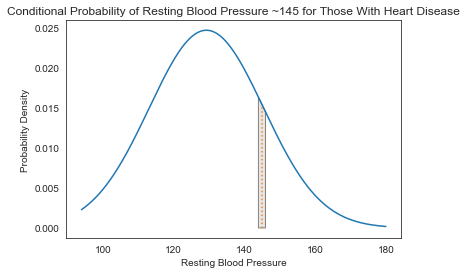

In [35]:
x = np.linspace(temp.min(), temp.max(), num=10**3)
pdf = stats.norm.pdf(x, loc=aggs['mean'], scale=aggs['std'])
xi = 145
width = 2
xi_lower = xi - width/2
xi_upper = xi + width/2

fig, ax = plt.subplots()

plt.plot(x, pdf)

# Make the shaded region
ix = np.linspace(xi_lower, xi_upper)
iy = stats.norm.pdf(ix, loc=aggs['mean'], scale=aggs['std'])
verts = [(xi_lower, 0), *zip(ix, iy), (xi_upper, 0)]
poly = Polygon(verts, facecolor='0.9', edgecolor='0.5')
ax.add_patch(poly);

plt.plot((145, 145), (0, stats.norm.pdf(145, loc=aggs['mean'], scale=aggs['std'])), linestyle='dotted')
p_area = stats.norm.cdf(xi_upper, loc=aggs['mean'], scale=aggs['std']) - stats.norm.cdf(xi_lower, loc=aggs['mean'], scale=aggs['std'])
print('Probability of Blood Pressure Falling withing Range for the Given Class: {}'.format(p_area))
plt.title('Conditional Probability of Resting Blood Pressure ~145 for Those With Heart Disease')
plt.ylabel('Probability Density')
plt.xlabel('Resting Blood Pressure')

> Comment: See https://matplotlib.org/gallery/showcase/integral.html for further details on plotting shaded integral areas under curves.

## Summary

Well done! In this lab, you implemented the Gaussian Naive Bayes classifier from scratch, and used it to generate classification predictions and validated the accuracy of the model.